# Notebook 04: Modelado y Evaluacion - Predictor Precio Cobre Chile

## Objetivo
Entrenar, evaluar y comparar dos modelos de prediccion para el precio del cobre:
1. **Linear Regression** - Modelo baseline con features engineered
2. **ARIMA** - Modelo especializado en series temporales

## Flujo del notebook:
1. Cargar datos procesados (output del notebook 03)
2. Split temporal: Train/Validation/Test (80/10/10)
3. Entrenar Linear Regression
4. Entrenar ARIMA  
5. Evaluar ambos modelos en test set
6. Comparar resultados
7. Seleccionar y guardar mejor modelo

---

## 1. IMPORTAR LIBRERIAS Y CARGAR DATOS

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Librerias importadas correctamente")

Librerias importadas correctamente


In [2]:
# Cargar datos procesados (output del notebook 03)
df = pd.read_csv('../data/processed/precio_cobre_features.csv')
df['fecha'] = pd.to_datetime(df['fecha'])

print("="*80)
print("DATOS CARGADOS")
print("="*80)
print(f"Registros: {len(df):,}")
print(f"Columnas: {len(df.columns):,}")
print(f"Features (sin fecha/precio): {len(df.columns) - 2:,}")
print(f"Rango temporal: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"\nPrimeras 5 columnas: {list(df.columns[:5])}")
print(f"Ultimas 5 columnas: {list(df.columns[-5:])}")

df.head()

DATOS CARGADOS
Registros: 3,872
Columnas: 44
Features (sin fecha/precio): 42
Rango temporal: 2010-05-13 00:00:00 a 2025-10-02 00:00:00

Primeras 5 columnas: ['fecha', 'precio', 'month', 'quarter', 'is_q2']
Ultimas 5 columnas: ['is_friday', 'is_midweek', 'day_of_month', 'is_month_start', 'is_month_end']


,fecha,precio,month,quarter,is_q2,month_sin,month_cos,is_high_season,price_pct_change,volatility_7d,...,rolling_max_30,price_range_30,price_position_in_range,day_of_week,is_monday,is_friday,is_midweek,day_of_month,is_month_start,is_month_end
0,2010-05-13,3.2195,5,2,1,0.5,-0.866025,1,0.013696,0.014176,...,3.6260,0.5225,0.222010,3,0,0,1,13,0,0
1,2010-05-14,3.1230,5,2,1,0.5,-0.866025,1,-0.029974,0.018608,...,3.6260,0.5225,0.037321,4,0,1,0,14,0,0
2,2010-05-17,2.9230,5,2,1,0.5,-0.866025,1,-0.064041,0.030548,...,3.6095,0.6865,0.000000,0,1,0,0,17,0,0
3,2010-05-18,3.0225,5,2,1,0.5,-0.866025,1,0.034040,0.034150,...,3.6055,0.6825,0.145787,1,0,0,1,18,0,0
4,2010-05-19,2.9500,5,2,1,0.5,-0.866025,1,-0.023987,0.031689,...,3.6055,0.6825,0.039560,2,0,0,1,19,0,0


---
## 2. SPLIT TEMPORAL DE DATOS

### IMPORTANTE: Split cronologico (SIN shuffle)
En series temporales, el split debe respetar el orden temporal:
- **Train**: Primeros 80% de datos (para entrenar)
- **Validation**: Siguientes 10% (para ajustar hiperparametros)
- **Test**: Ultimos 10% (para evaluacion final)

Esto simula la prediccion real: usar datos del pasado para predecir el futuro.

In [3]:
# Calcular indices de corte
n = len(df)
train_size = int(0.8 * n)
val_size = int(0.1 * n)
# test_size sera el resto

# Split temporal (SIN shuffle)
train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

print("="*80)
print("SPLIT TEMPORAL")
print("="*80)
print(f"\nTRAIN:")
print(f"  Registros: {len(train_df):,}")
print(f"  Periodo: {train_df['fecha'].min()} a {train_df['fecha'].max()}")
print(f"  Porcentaje: {len(train_df)/n*100:.1f}%")

print(f"\nVALIDATION:")
print(f"  Registros: {len(val_df):,}")
print(f"  Periodo: {val_df['fecha'].min()} a {val_df['fecha'].max()}")
print(f"  Porcentaje: {len(val_df)/n*100:.1f}%")

print(f"\nTEST:")
print(f"  Registros: {len(test_df):,}")
print(f"  Periodo: {test_df['fecha'].min()} a {test_df['fecha'].max()}")
print(f"  Porcentaje: {len(test_df)/n*100:.1f}%")
print("="*80)

SPLIT TEMPORAL

TRAIN:
  Registros: 3,097
  Periodo: 2010-05-13 00:00:00 a 2022-09-02 00:00:00
  Porcentaje: 80.0%

VALIDATION:
  Registros: 387
  Periodo: 2022-09-06 00:00:00 a 2024-03-19 00:00:00
  Porcentaje: 10.0%

TEST:
  Registros: 388
  Periodo: 2024-03-20 00:00:00 a 2025-10-02 00:00:00
  Porcentaje: 10.0%


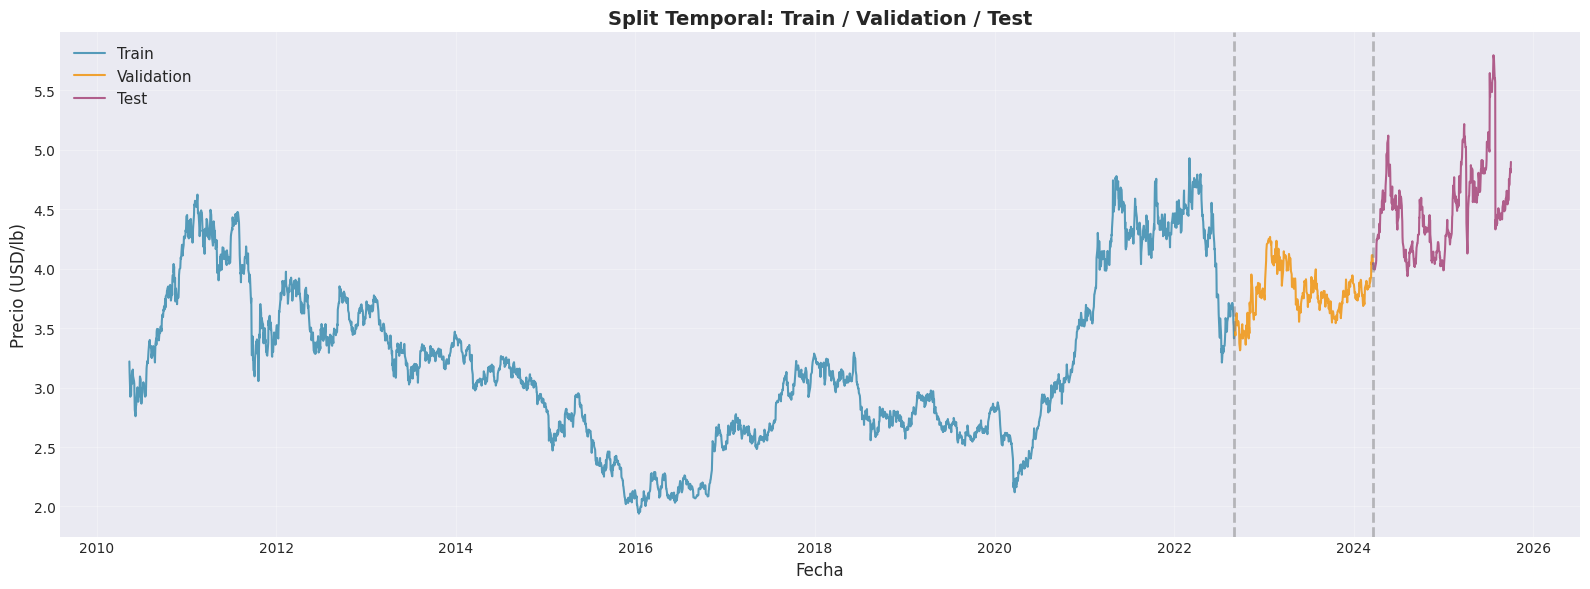

Visualizacion: Se observa claramente la separacion cronologica de los conjuntos.


In [4]:
# Visualizar el split
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(train_df['fecha'], train_df['precio'], label='Train', color='#2E86AB', linewidth=1.5, alpha=0.8)
ax.plot(val_df['fecha'], val_df['precio'], label='Validation', color='#F18F01', linewidth=1.5, alpha=0.8)
ax.plot(test_df['fecha'], test_df['precio'], label='Test', color='#A23B72', linewidth=1.5, alpha=0.8)

# Lineas verticales para separar splits
ax.axvline(x=train_df['fecha'].iloc[-1], color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax.axvline(x=val_df['fecha'].iloc[-1], color='gray', linestyle='--', linewidth=2, alpha=0.5)

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Precio (USD/lb)', fontsize=12)
ax.set_title('Split Temporal: Train / Validation / Test', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizacion: Se observa claramente la separacion cronologica de los conjuntos.")

---
## 3. PREPARAR FEATURES Y TARGET

Separar las features (X) del target (y) para cada conjunto.

In [5]:
# Definir que columnas son features y cual es el target
target_col = 'precio'
exclude_cols = ['fecha', 'precio']  # Columnas que NO son features

# Obtener nombres de features
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total de features: {len(feature_cols)}")
print(f"\nPrimeras 10 features:")
for i, feat in enumerate(feature_cols[:10], 1):
    print(f"  {i:2d}. {feat}")

# Separar X (features) e y (target)
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\n{'='*80}")
print("DIMENSIONES DE LOS DATOS")
print("="*80)
print(f"Train - X: {X_train.shape}, y: {y_train.shape}")
print(f"Val   - X: {X_val.shape}, y: {y_val.shape}")
print(f"Test  - X: {X_test.shape}, y: {y_test.shape}")
print("="*80)

Total de features: 42

Primeras 10 features:
   1. month
   2. quarter
   3. is_q2
   4. month_sin
   5. month_cos
   6. is_high_season
   7. price_pct_change
   8. volatility_7d
   9. volatility_30d
  10. volatility_90d

DIMENSIONES DE LOS DATOS
Train - X: (3097, 42), y: (3097,)
Val   - X: (387, 42), y: (387,)
Test  - X: (388, 42), y: (388,)


---
# MODELO 1: LINEAR REGRESSION
---

## 4. ENTRENAR LINEAR REGRESSION

Linear Regression es un modelo baseline simple pero efectivo. Usa todas las features creadas en el notebook 03 para predecir el precio.

In [6]:
# Crear y entrenar modelo
print("Entrenando Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones en train y validation
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular metricas en train
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Calcular metricas en validation
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

print("\n" + "="*80)
print("LINEAR REGRESSION - METRICAS DE ENTRENAMIENTO")
print("="*80)
print(f"\nTRAIN:")
print(f"  MAE:  {train_mae:.4f} USD/lb")
print(f"  RMSE: {train_rmse:.4f} USD/lb")
print(f"  R2:   {train_r2:.4f} ({train_r2*100:.2f}% de varianza explicada)")
print(f"  MAPE: {train_mape:.2f}%")

print(f"\nVALIDATION:")
print(f"  MAE:  {val_mae:.4f} USD/lb")
print(f"  RMSE: {val_rmse:.4f} USD/lb")
print(f"  R2:   {val_r2:.4f} ({val_r2*100:.2f}% de varianza explicada)")
print(f"  MAPE: {val_mape:.2f}%")
print("="*80)

print("\nModelo Linear Regression entrenado exitosamente.")

Entrenando Linear Regression...

LINEAR REGRESSION - METRICAS DE ENTRENAMIENTO

TRAIN:
  MAE:  0.0061 USD/lb
  RMSE: 0.0096 USD/lb
  R2:   0.9998 (99.98% de varianza explicada)
  MAPE: 0.20%

VALIDATION:
  MAE:  0.0050 USD/lb
  RMSE: 0.0069 USD/lb
  R2:   0.9987 (99.87% de varianza explicada)
  MAPE: 0.13%

Modelo Linear Regression entrenado exitosamente.


## 5. FEATURE IMPORTANCE (LINEAR REGRESSION)

Analizar que features son mas importantes segun los coeficientes del modelo.

Top 20 Features mas Importantes (Linear Regression):

   1. price_pct_change              : +2.368834
   2. price_vs_ma_30                : +1.980669
   3. trend_7_30                    : -1.961267
   4. lag_1                         : +0.725387
   5. volatility_7d                 : -0.653440
   6. volatility_30d                : +0.649905
   7. price_vs_ma_7                 : -0.623504
   8. momentum_7                    : -0.419028
   9. rolling_mean_7                : +0.413486
  10. lag_7                         : -0.123966
  11. volatility_90d                : +0.111156
  12. abs_price_change              : -0.017914
  13. rolling_std_30                : +0.014142
  14. lag_2                         : -0.012752
  15. rolling_min_30                : +0.008753
  16. volatility_ratio              : +0.007587
  17. lag_3                         : -0.007290
  18. extreme_move_flag             : +0.006791
  19. price_range_30                : -0.005004
  20. rolling_max_30              

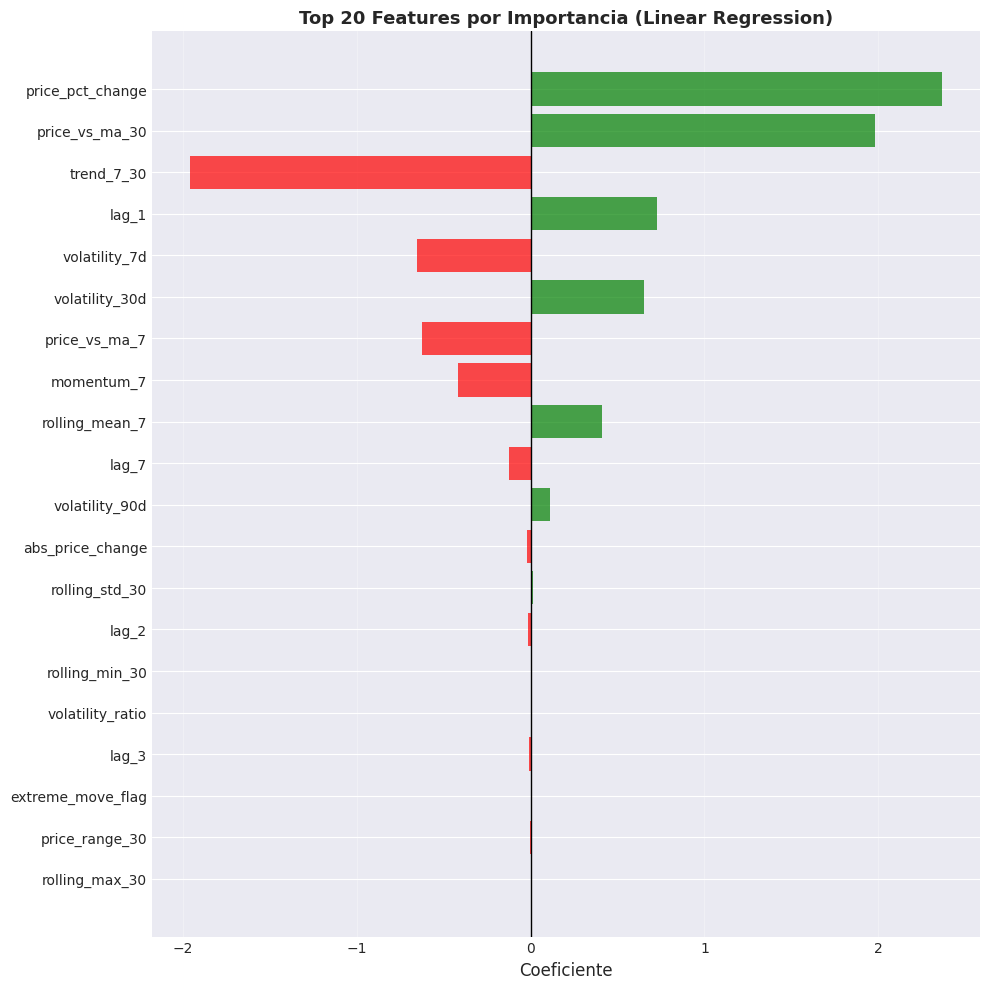


Interpretacion:
  - Verde: Feature con impacto positivo en el precio
  - Rojo: Feature con impacto negativo en el precio
  - Magnitud: Mientras mayor el valor absoluto, mayor el impacto


In [7]:
# Obtener coeficientes (importancia) de cada feature
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_
})

# Ordenar por valor absoluto del coeficiente (mayor impacto)
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

# Top 20 features mas importantes
top_20 = feature_importance.head(20)

print("Top 20 Features mas Importantes (Linear Regression):\n")
for i, row in enumerate(top_20.itertuples(), 1):
    print(f"  {i:2d}. {row.feature:30s}: {row.coefficient:+.6f}")

# Grafico
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['green' if c > 0 else 'red' for c in top_20['coefficient']]
ax.barh(range(len(top_20)), top_20['coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'], fontsize=10)
ax.set_xlabel('Coeficiente', fontsize=12)
ax.set_title('Top 20 Features por Importancia (Linear Regression)', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nInterpretacion:")
print("  - Verde: Feature con impacto positivo en el precio")
print("  - Rojo: Feature con impacto negativo en el precio")
print("  - Magnitud: Mientras mayor el valor absoluto, mayor el impacto")

## 6. PREDICCIONES EN TEST SET (LINEAR REGRESSION)

Evaluar el modelo en datos que NUNCA ha visto (test set).

In [8]:
# Predicciones en test
y_test_pred_lr = lr_model.predict(X_test)

# Calcular metricas en test
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_test_r2 = r2_score(y_test, y_test_pred_lr)
lr_test_mape = np.mean(np.abs((y_test - y_test_pred_lr) / y_test)) * 100

print("="*80)
print("LINEAR REGRESSION - METRICAS EN TEST SET")
print("="*80)
print(f"MAE:  {lr_test_mae:.4f} USD/lb")
print(f"RMSE: {lr_test_rmse:.4f} USD/lb")
print(f"R2:   {lr_test_r2:.4f} ({lr_test_r2*100:.2f}% de varianza explicada)")
print(f"MAPE: {lr_test_mape:.2f}%")
print("="*80)

# Guardar metricas para comparacion posterior
lr_metrics = {
    'model': 'Linear Regression',
    'train_mae': train_mae,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'val_mae': val_mae,
    'val_rmse': val_rmse,
    'val_r2': val_r2,
    'test_mae': lr_test_mae,
    'test_rmse': lr_test_rmse,
    'test_r2': lr_test_r2,
    'test_mape': lr_test_mape
}

LINEAR REGRESSION - METRICAS EN TEST SET
MAE:  0.0169 USD/lb
RMSE: 0.0326 USD/lb
R2:   0.9923 (99.23% de varianza explicada)
MAPE: 0.37%


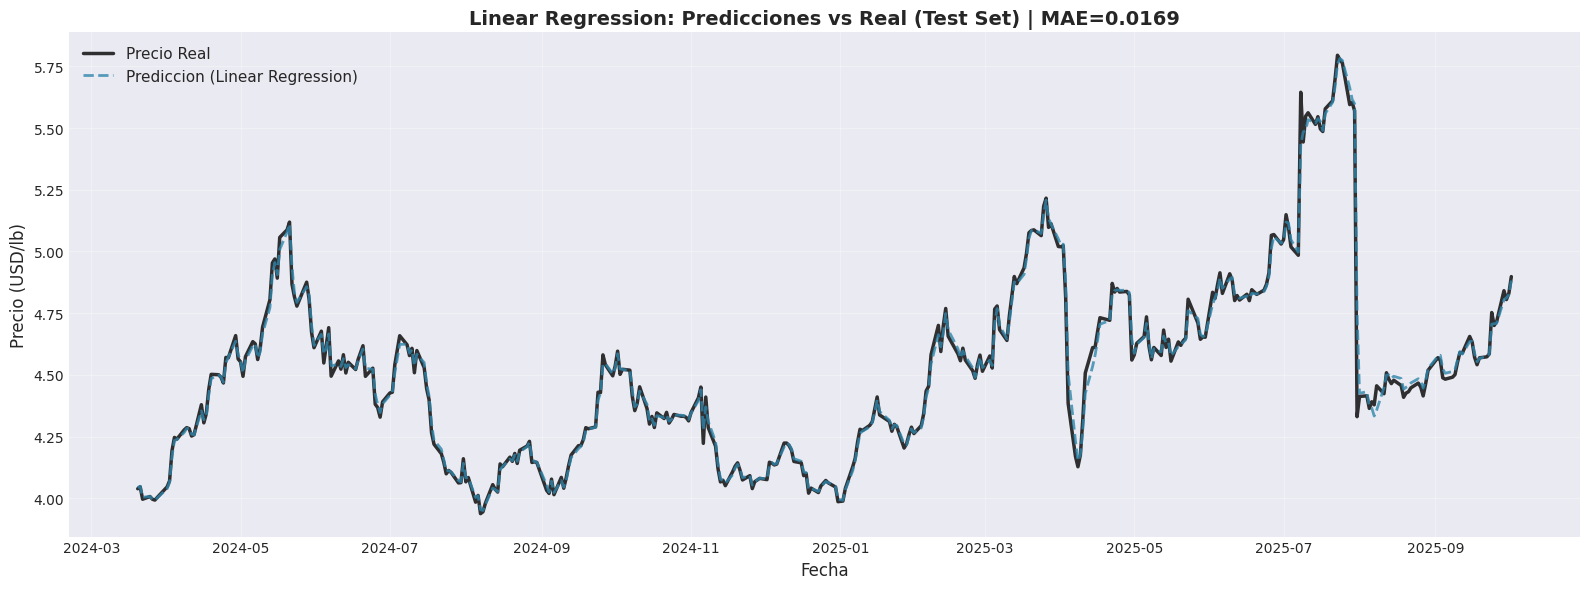

Observacion: El modelo sigue la tendencia general bastante bien.


In [9]:
# Grafico: Predicciones vs Real (Test Set)
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test_df['fecha'], y_test.values, label='Precio Real', linewidth=2.5, color='black', alpha=0.8)
ax.plot(test_df['fecha'], y_test_pred_lr, label='Prediccion (Linear Regression)', 
        linewidth=2, linestyle='--', color='#2E86AB', alpha=0.8)

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Precio (USD/lb)', fontsize=12)
ax.set_title(f'Linear Regression: Predicciones vs Real (Test Set) | MAE={lr_test_mae:.4f}', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observacion: El modelo sigue la tendencia general bastante bien.")

## 7. ANALISIS DE RESIDUALES (LINEAR REGRESSION)

Los residuales son la diferencia entre el valor real y el predicho. Un buen modelo debe tener residuales:
- Centrados en 0 (sin sesgo)
- Distribuidos normalmente
- Sin patrones evidentes (aleatorios)

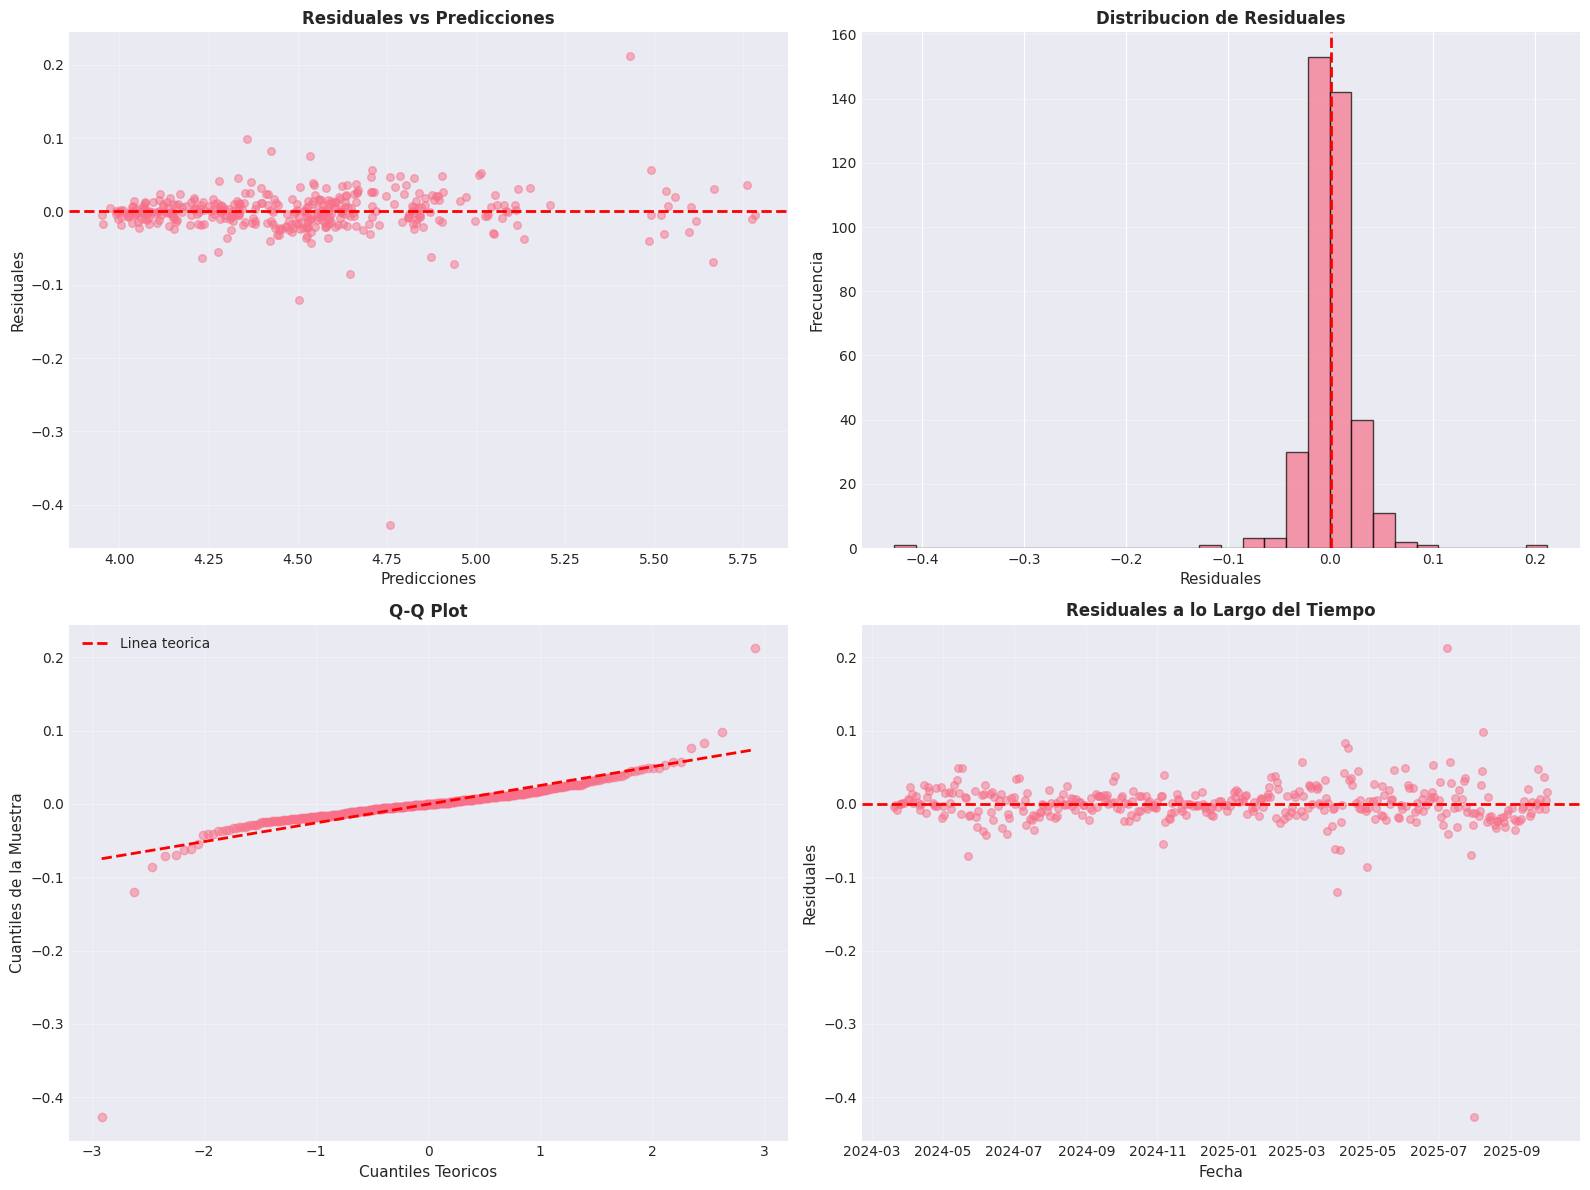


Interpretacion:
  1. Residuales vs Predicciones: Debe mostrar dispersion aleatoria sin patron
  2. Histograma: Debe parecer una campana (distribucion normal)
  3. Q-Q Plot: Puntos cerca de la linea roja indican normalidad
  4. Residuales vs Tiempo: No debe haber tendencias obvias


In [10]:
# Calcular residuales
residuals_lr = y_test.values - y_test_pred_lr

# Crear graficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residuales vs Predicciones
axes[0, 0].scatter(y_test_pred_lr, residuals_lr, alpha=0.5, s=30)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicciones', fontsize=11)
axes[0, 0].set_ylabel('Residuales', fontsize=11)
axes[0, 0].set_title('Residuales vs Predicciones', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histograma de residuales
axes[0, 1].hist(residuals_lr, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuales', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribucion de Residuales', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q Plot (comparar con distribucion normal)
from scipy import stats as sp_stats
(osm, osr), (slope, intercept, r) = sp_stats.probplot(residuals_lr, dist="norm", plot=None)
axes[1, 0].scatter(osm, osr, alpha=0.5)
axes[1, 0].plot(osm, slope * osm + intercept, 'r--', linewidth=2, label='Linea teorica')
axes[1, 0].set_xlabel('Cuantiles Teoricos', fontsize=11)
axes[1, 0].set_ylabel('Cuantiles de la Muestra', fontsize=11)
axes[1, 0].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuales a lo largo del tiempo
axes[1, 1].scatter(test_df['fecha'], residuals_lr, alpha=0.5, s=30)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Fecha', fontsize=11)
axes[1, 1].set_ylabel('Residuales', fontsize=11)
axes[1, 1].set_title('Residuales a lo Largo del Tiempo', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretacion:")
print("  1. Residuales vs Predicciones: Debe mostrar dispersion aleatoria sin patron")
print("  2. Histograma: Debe parecer una campana (distribucion normal)")
print("  3. Q-Q Plot: Puntos cerca de la linea roja indican normalidad")
print("  4. Residuales vs Tiempo: No debe haber tendencias obvias")

---
# MODELO 2: ARIMA
---

## 8. ENTRENAR ARIMA

ARIMA (AutoRegressive Integrated Moving Average) es un modelo especializado en series temporales.
- **NO usa features adicionales**, solo la serie temporal del precio
- **Orden ARIMA (p, d, q)**:
  - p=5: Usa ultimos 5 valores (componente autoregresivo)
  - d=1: Diferenciacion de primer orden (para estacionariedad)
  - q=2: Media movil de ultimos 2 errores

In [11]:
# Preparar serie temporal para ARIMA (solo train)
train_series = train_df['precio']

# Definir orden ARIMA
arima_order = (5, 1, 2)

print(f"Entrenando ARIMA con orden {arima_order}...")
print("Esto puede tomar unos segundos...\n")

# Crear y entrenar modelo ARIMA
arima_model = ARIMA(train_series, order=arima_order)
arima_fitted = arima_model.fit()

print("Modelo ARIMA entrenado exitosamente.\n")
print("="*80)
print("RESUMEN DEL MODELO ARIMA")
print("="*80)
print(arima_fitted.summary())

Entrenando ARIMA con orden (5, 1, 2)...
Esto puede tomar unos segundos...

Modelo ARIMA entrenado exitosamente.

RESUMEN DEL MODELO ARIMA
                               SARIMAX Results                                
Dep. Variable:                 precio   No. Observations:                 3097
Model:                 ARIMA(5, 1, 2)   Log Likelihood                5042.307
Date:                Sun, 05 Oct 2025   AIC                         -10068.614
Time:                        03:44:17   BIC                         -10020.311
Sample:                             0   HQIC                        -10051.267
                               - 3097                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4508      0.195      2.310      0.021       0.068      

## 9. DIAGNOSTICO DEL MODELO ARIMA

Verificar la calidad del ajuste mediante graficos de diagnostico.

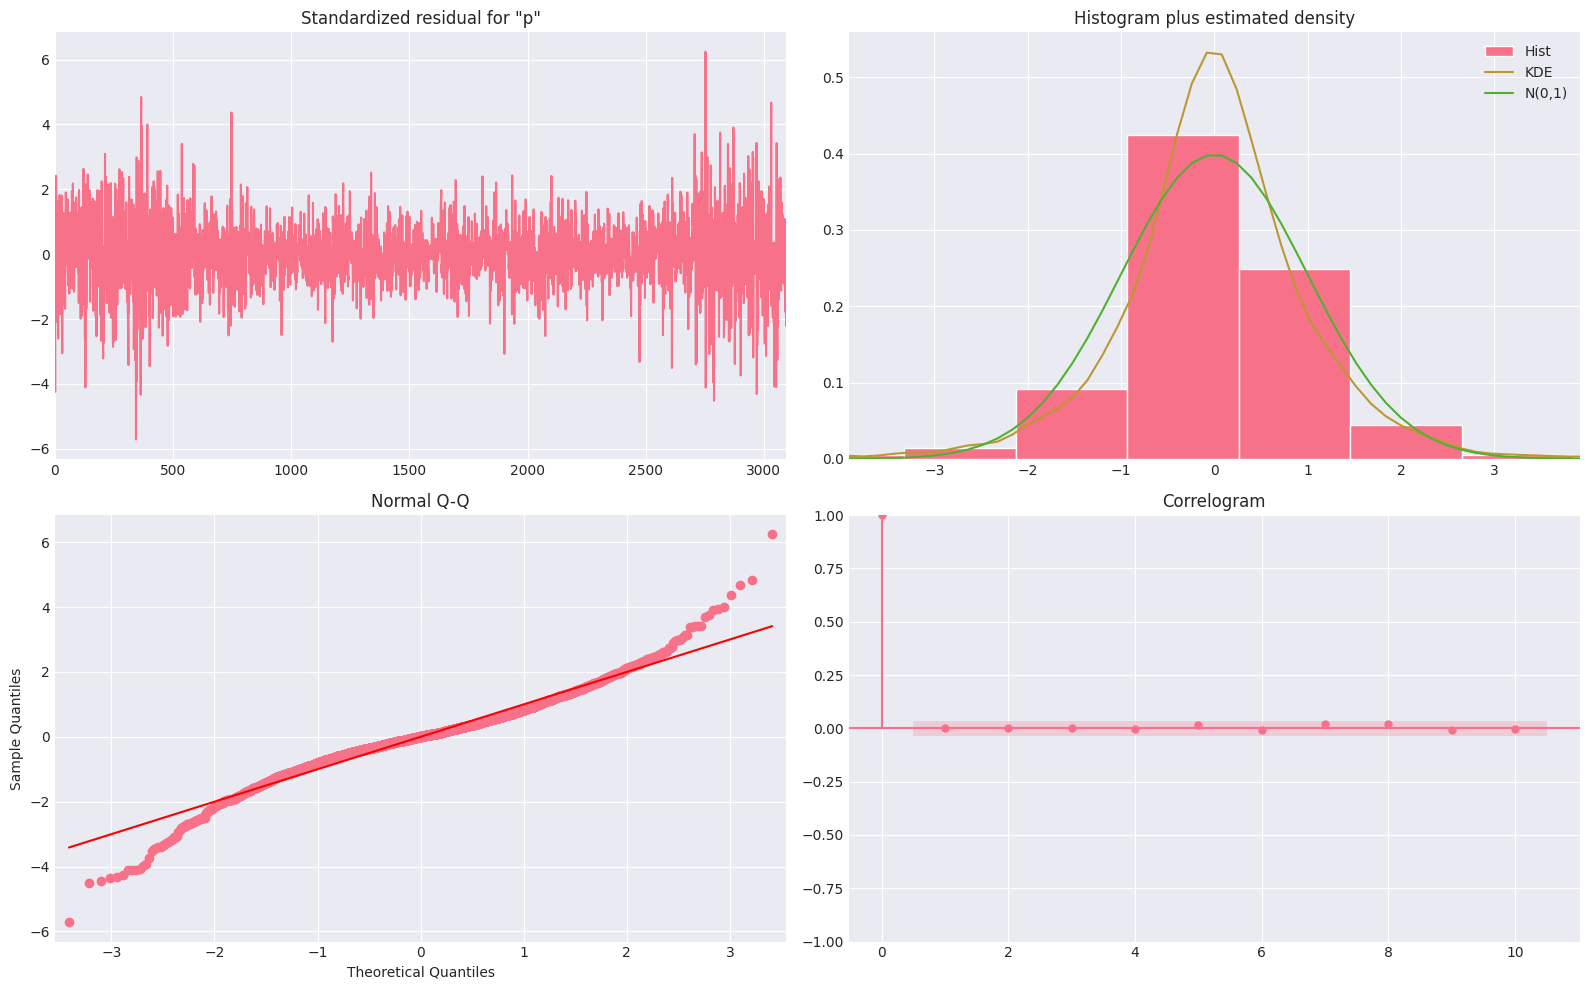


Interpretacion del diagnostico:
  1. Standardized residual: Debe fluctuar alrededor de 0 sin tendencia
  2. Histogram + KDE: Debe parecer una distribucion normal
  3. Q-Q plot: Puntos cerca de la linea roja indican normalidad
  4. Correlogram (ACF): Residuales NO deben estar autocorrelacionados


In [12]:
# Grafico de diagnostico
arima_fitted.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

print("\nInterpretacion del diagnostico:")
print("  1. Standardized residual: Debe fluctuar alrededor de 0 sin tendencia")
print("  2. Histogram + KDE: Debe parecer una distribucion normal")
print("  3. Q-Q plot: Puntos cerca de la linea roja indican normalidad")
print("  4. Correlogram (ACF): Residuales NO deben estar autocorrelacionados")

## 10. PREDICCIONES EN TEST SET (ARIMA)

ARIMA predice paso a paso (forecast) usando solo la serie temporal.

In [13]:
# Predecir en test set
# start: primer indice del test
# end: ultimo indice del test
start_idx = len(train_series)
end_idx = len(train_series) + len(test_df) - 1

print(f"Generando predicciones ARIMA para {len(test_df)} periodos...")
y_test_pred_arima = arima_fitted.predict(start=start_idx, end=end_idx)

# Calcular metricas en test
arima_test_mae = mean_absolute_error(y_test, y_test_pred_arima)
arima_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_arima))
arima_test_r2 = r2_score(y_test, y_test_pred_arima)
arima_test_mape = np.mean(np.abs((y_test - y_test_pred_arima) / y_test)) * 100

print("\n" + "="*80)
print("ARIMA - METRICAS EN TEST SET")
print("="*80)
print(f"MAE:  {arima_test_mae:.4f} USD/lb")
print(f"RMSE: {arima_test_rmse:.4f} USD/lb")
print(f"R2:   {arima_test_r2:.4f} ({arima_test_r2*100:.2f}% de varianza explicada)")
print(f"MAPE: {arima_test_mape:.2f}%")
print("="*80)

# Guardar metricas para comparacion
arima_metrics = {
    'model': 'ARIMA',
    'test_mae': arima_test_mae,
    'test_rmse': arima_test_rmse,
    'test_r2': arima_test_r2,
    'test_mape': arima_test_mape
}

Generando predicciones ARIMA para 388 periodos...

ARIMA - METRICAS EN TEST SET
MAE:  1.0794 USD/lb
RMSE: 1.1415 USD/lb
R2:   -8.4449 (-844.49% de varianza explicada)
MAPE: 14.91%


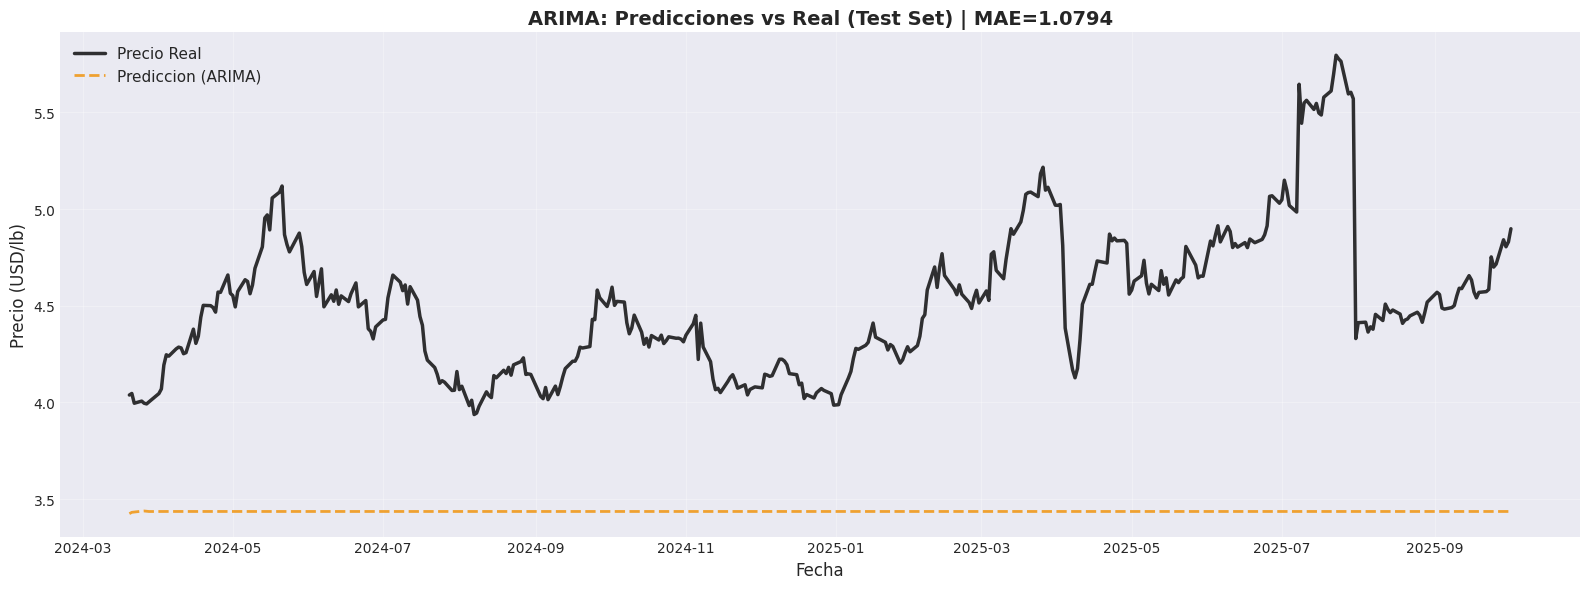

In [14]:
# Grafico: Predicciones vs Real (Test Set)
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test_df['fecha'], y_test.values, label='Precio Real', linewidth=2.5, color='black', alpha=0.8)
ax.plot(test_df['fecha'], y_test_pred_arima, label='Prediccion (ARIMA)', 
        linewidth=2, linestyle='--', color='#F18F01', alpha=0.8)

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Precio (USD/lb)', fontsize=12)
ax.set_title(f'ARIMA: Predicciones vs Real (Test Set) | MAE={arima_test_mae:.4f}', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. ANALISIS DE RESIDUALES (ARIMA)

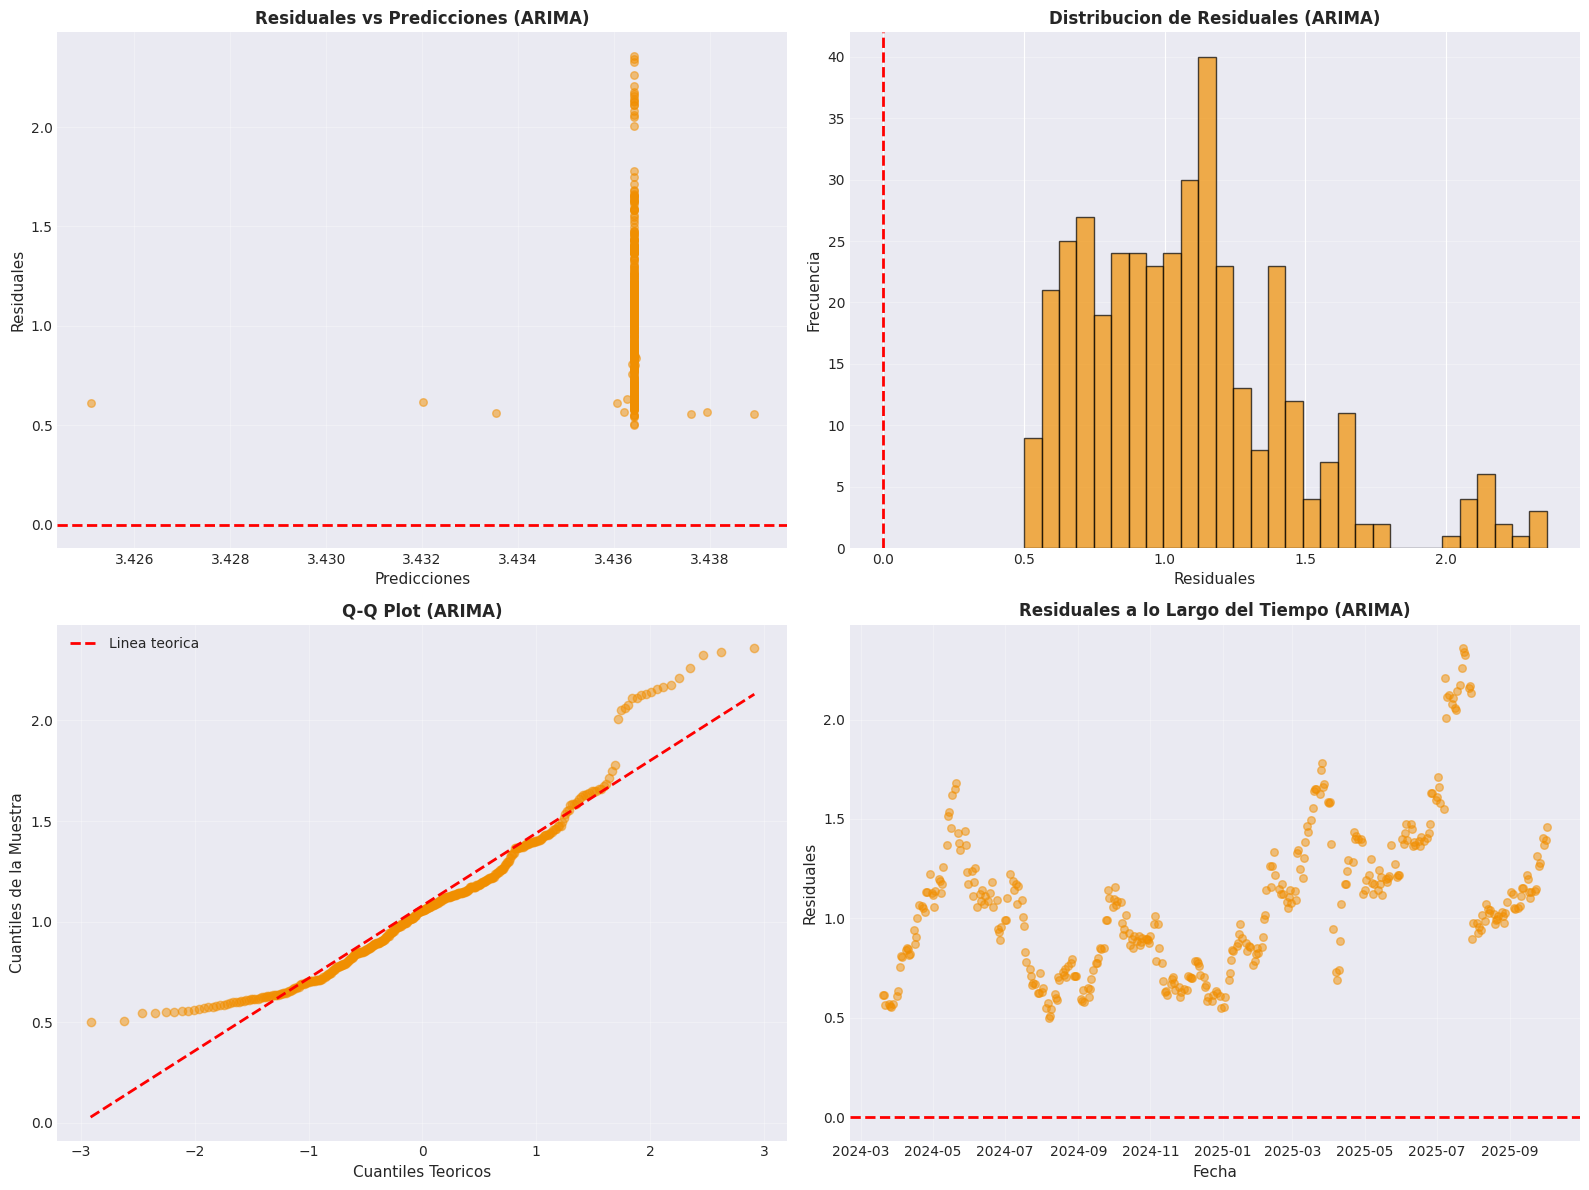

In [15]:
# Calcular residuales
residuals_arima = y_test.values - y_test_pred_arima.values

# Crear graficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residuales vs Predicciones
axes[0, 0].scatter(y_test_pred_arima, residuals_arima, alpha=0.5, s=30, color='#F18F01')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicciones', fontsize=11)
axes[0, 0].set_ylabel('Residuales', fontsize=11)
axes[0, 0].set_title('Residuales vs Predicciones (ARIMA)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histograma de residuales
axes[0, 1].hist(residuals_arima, bins=30, edgecolor='black', alpha=0.7, color='#F18F01')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuales', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribucion de Residuales (ARIMA)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q Plot
(osm, osr), (slope, intercept, r) = sp_stats.probplot(residuals_arima, dist="norm", plot=None)
axes[1, 0].scatter(osm, osr, alpha=0.5, color='#F18F01')
axes[1, 0].plot(osm, slope * osm + intercept, 'r--', linewidth=2, label='Linea teorica')
axes[1, 0].set_xlabel('Cuantiles Teoricos', fontsize=11)
axes[1, 0].set_ylabel('Cuantiles de la Muestra', fontsize=11)
axes[1, 0].set_title('Q-Q Plot (ARIMA)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuales a lo largo del tiempo
axes[1, 1].scatter(test_df['fecha'], residuals_arima, alpha=0.5, s=30, color='#F18F01')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Fecha', fontsize=11)
axes[1, 1].set_ylabel('Residuales', fontsize=11)
axes[1, 1].set_title('Residuales a lo Largo del Tiempo (ARIMA)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# COMPARACION DE MODELOS
---

## 12. TABLA COMPARATIVA DE METRICAS

In [16]:
# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Modelo': ['Linear Regression', 'ARIMA'],
    'MAE (Test)': [lr_test_mae, arima_test_mae],
    'RMSE (Test)': [lr_test_rmse, arima_test_rmse],
    'R2 (Test)': [lr_test_r2, arima_test_r2],
    'MAPE (Test)': [lr_test_mape, arima_test_mape]
})

print("="*80)
print("COMPARACION DE MODELOS - TEST SET")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identificar mejor modelo por cada metrica
best_mae = comparison_df.loc[comparison_df['MAE (Test)'].idxmin(), 'Modelo']
best_rmse = comparison_df.loc[comparison_df['RMSE (Test)'].idxmin(), 'Modelo']
best_r2 = comparison_df.loc[comparison_df['R2 (Test)'].idxmax(), 'Modelo']
best_mape = comparison_df.loc[comparison_df['MAPE (Test)'].idxmin(), 'Modelo']

print(f"\nMejor modelo por metrica:")
print(f"  MAE:  {best_mae}")
print(f"  RMSE: {best_rmse}")
print(f"  R2:   {best_r2}")
print(f"  MAPE: {best_mape}")

COMPARACION DE MODELOS - TEST SET
           Modelo  MAE (Test)  RMSE (Test)  R2 (Test)  MAPE (Test)
Linear Regression    0.016910     0.032599   0.992297     0.368110
            ARIMA    1.079386     1.141489  -8.444892    14.908373

Mejor modelo por metrica:
  MAE:  Linear Regression
  RMSE: Linear Regression
  R2:   Linear Regression
  MAPE: Linear Regression


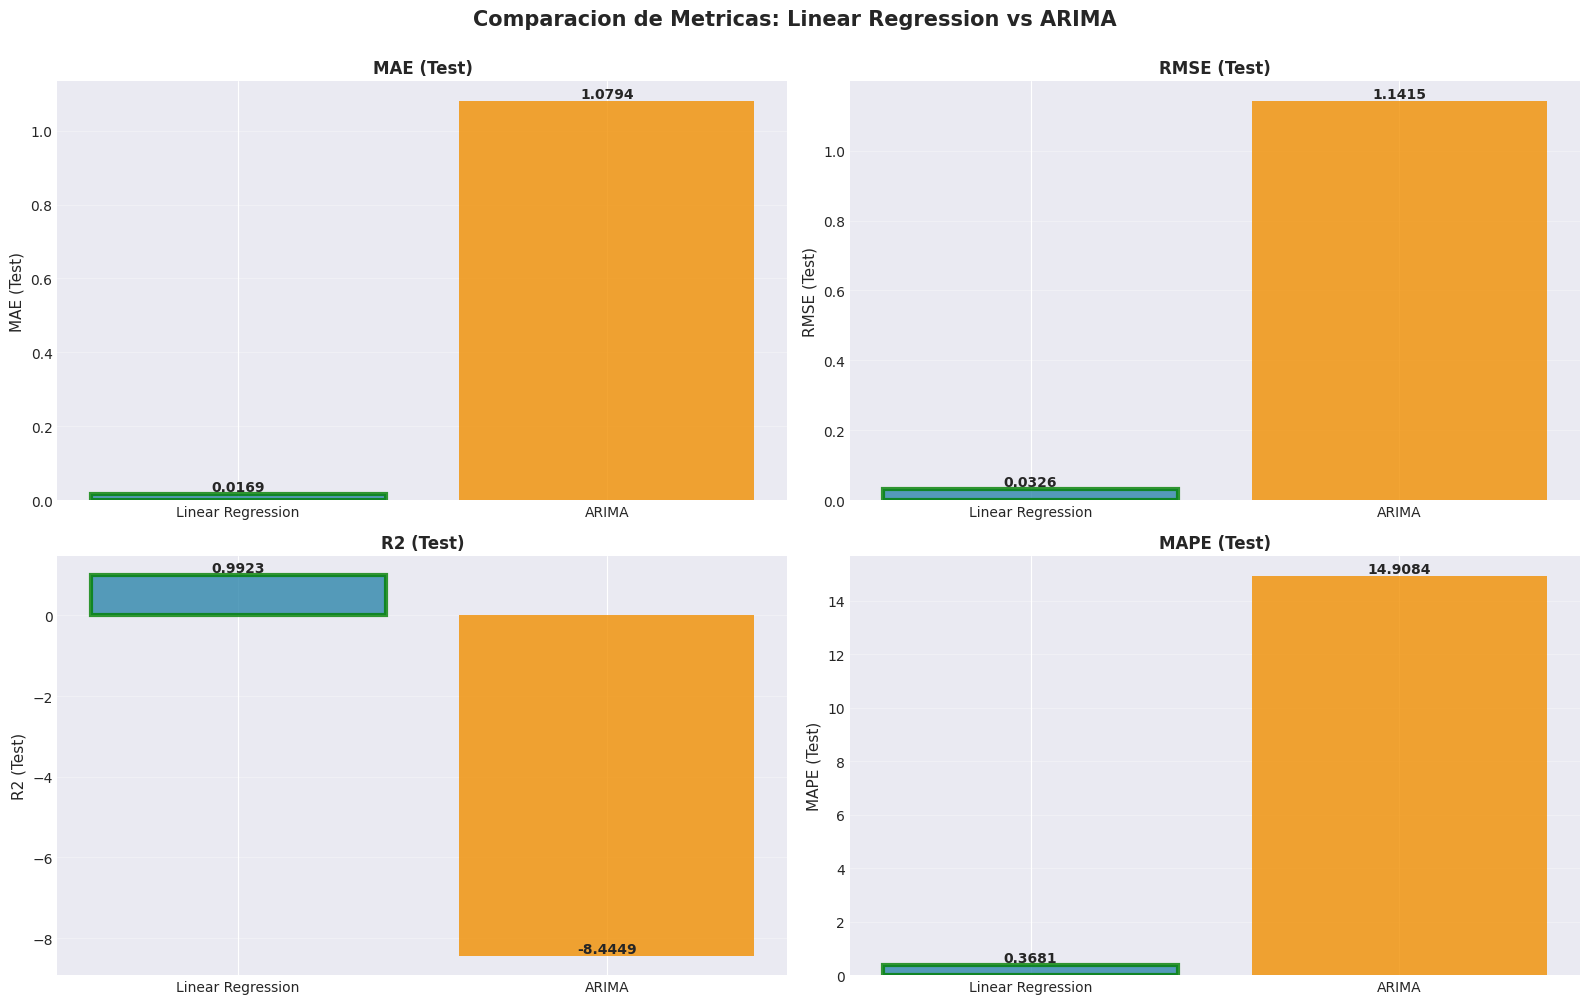

Nota: El mejor modelo en cada metrica esta resaltado con borde verde.


In [17]:
# Grafico comparativo de metricas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['MAE (Test)', 'RMSE (Test)', 'R2 (Test)', 'MAPE (Test)']
colors = ['#2E86AB', '#F18F01']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    values = comparison_df[metric].values
    bars = ax.bar(['Linear Regression', 'ARIMA'], values, color=colors, alpha=0.8)
    
    # Destacar el mejor
    if metric == 'R2 (Test)':
        best_idx = np.argmax(values)
    else:
        best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('green')
    bars[best_idx].set_linewidth(3)
    
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Agregar valores en las barras
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparacion de Metricas: Linear Regression vs ARIMA', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Nota: El mejor modelo en cada metrica esta resaltado con borde verde.")

## 13. COMPARACION VISUAL: AMBOS MODELOS VS REAL

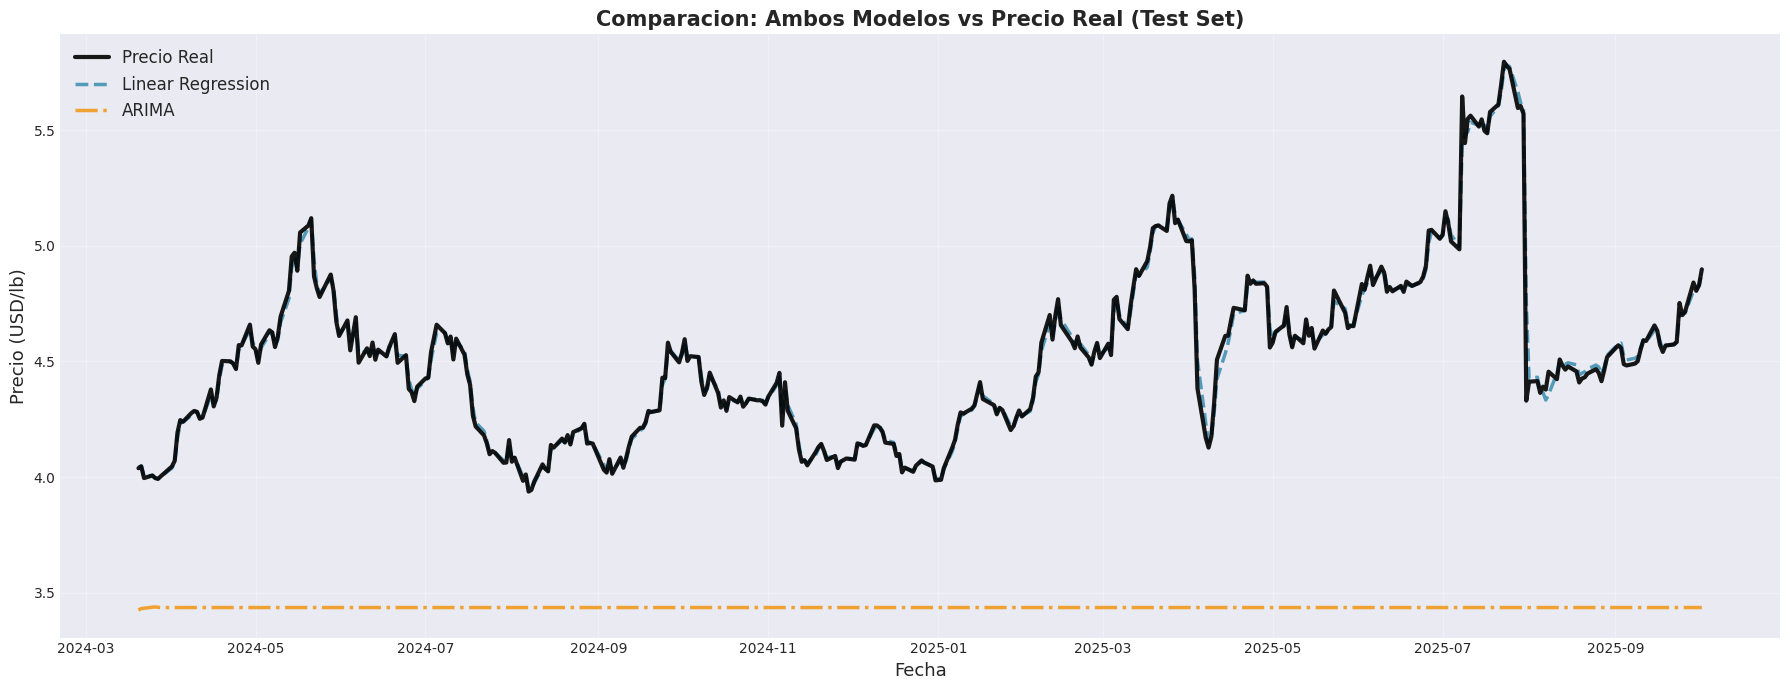

Observacion: Ambos modelos siguen la tendencia general,
pero pueden tener diferencias en la magnitud de las predicciones.


In [18]:
# Grafico con ambas predicciones
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(test_df['fecha'], y_test.values, label='Precio Real', 
        linewidth=3, color='black', alpha=0.9, zorder=3)
ax.plot(test_df['fecha'], y_test_pred_lr, label='Linear Regression', 
        linewidth=2.5, linestyle='--', color='#2E86AB', alpha=0.8)
ax.plot(test_df['fecha'], y_test_pred_arima, label='ARIMA', 
        linewidth=2.5, linestyle='-.', color='#F18F01', alpha=0.8)

ax.set_xlabel('Fecha', fontsize=13)
ax.set_ylabel('Precio (USD/lb)', fontsize=13)
ax.set_title('Comparacion: Ambos Modelos vs Precio Real (Test Set)', 
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observacion: Ambos modelos siguen la tendencia general,")
print("pero pueden tener diferencias en la magnitud de las predicciones.")

## 14. VERIFICACION DE METRICAS OBJETIVO

Segun el proyecto, las metricas objetivo son:
- **R2 >= 0.85** (85% de varianza explicada)
- **MAE <= 0.15** USD/lb
- **RMSE <= 0.20** USD/lb

In [19]:
# Metricas objetivo
target_r2 = 0.85
target_mae = 0.15
target_rmse = 0.20

print("="*80)
print("VERIFICACION DE METRICAS OBJETIVO")
print("="*80)

print(f"\nLINEAR REGRESSION:")
lr_meets_r2 = "CUMPLE" if lr_test_r2 >= target_r2 else "NO CUMPLE"
lr_meets_mae = "CUMPLE" if lr_test_mae <= target_mae else "NO CUMPLE"
lr_meets_rmse = "CUMPLE" if lr_test_rmse <= target_rmse else "NO CUMPLE"

print(f"  R2:   {lr_test_r2:.4f}  (objetivo: >= {target_r2})  [{lr_meets_r2}]")
print(f"  MAE:  {lr_test_mae:.4f}  (objetivo: <= {target_mae})  [{lr_meets_mae}]")
print(f"  RMSE: {lr_test_rmse:.4f}  (objetivo: <= {target_rmse})  [{lr_meets_rmse}]")

print(f"\nARIMA:")
arima_meets_r2 = "CUMPLE" if arima_test_r2 >= target_r2 else "NO CUMPLE"
arima_meets_mae = "CUMPLE" if arima_test_mae <= target_mae else "NO CUMPLE"
arima_meets_rmse = "CUMPLE" if arima_test_rmse <= target_rmse else "NO CUMPLE"

print(f"  R2:   {arima_test_r2:.4f}  (objetivo: >= {target_r2})  [{arima_meets_r2}]")
print(f"  MAE:  {arima_test_mae:.4f}  (objetivo: <= {target_mae})  [{arima_meets_mae}]")
print(f"  RMSE: {arima_test_rmse:.4f}  (objetivo: <= {target_rmse})  [{arima_meets_rmse}]")

print("="*80)

VERIFICACION DE METRICAS OBJETIVO

LINEAR REGRESSION:
  R2:   0.9923  (objetivo: >= 0.85)  [CUMPLE]
  MAE:  0.0169  (objetivo: <= 0.15)  [CUMPLE]
  RMSE: 0.0326  (objetivo: <= 0.2)  [CUMPLE]

ARIMA:
  R2:   -8.4449  (objetivo: >= 0.85)  [NO CUMPLE]
  MAE:  1.0794  (objetivo: <= 0.15)  [NO CUMPLE]
  RMSE: 1.1415  (objetivo: <= 0.2)  [NO CUMPLE]


## 15. SELECCIONAR MEJOR MODELO

In [20]:
# Seleccionar mejor modelo basado en MAE (error absoluto promedio)
if lr_test_mae < arima_test_mae:
    best_model_name = 'Linear Regression'
    best_model = lr_model
    best_mae = lr_test_mae
    best_rmse = lr_test_rmse
    best_r2 = lr_test_r2
    best_mape = lr_test_mape
else:
    best_model_name = 'ARIMA'
    best_model = arima_fitted
    best_mae = arima_test_mae
    best_rmse = arima_test_rmse
    best_r2 = arima_test_r2
    best_mape = arima_test_mape

print("\n" + "="*80)
print(f"MEJOR MODELO SELECCIONADO: {best_model_name}")
print("="*80)
print(f"\nMetricas en Test Set:")
print(f"  MAE:  {best_mae:.4f} USD/lb")
print(f"  RMSE: {best_rmse:.4f} USD/lb")
print(f"  R2:   {best_r2:.4f} ({best_r2*100:.2f}% de varianza explicada)")
print(f"  MAPE: {best_mape:.2f}%")
print("\n" + "="*80)
print(f"Criterio de seleccion: Menor MAE (Mean Absolute Error)")
print("="*80)


MEJOR MODELO SELECCIONADO: Linear Regression

Metricas en Test Set:
  MAE:  0.0169 USD/lb
  RMSE: 0.0326 USD/lb
  R2:   0.9923 (99.23% de varianza explicada)
  MAPE: 0.37%

Criterio de seleccion: Menor MAE (Mean Absolute Error)


## 16. GUARDAR MODELOS

In [21]:
# Crear directorio de modelos si no existe
import os
os.makedirs('../models', exist_ok=True)

# Guardar Linear Regression
with open('../models/linear_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("Linear Regression guardado en: ../models/linear_regression.pkl")

# Guardar ARIMA
with open('../models/arima_model.pkl', 'wb') as f:
    pickle.dump(arima_fitted, f)
print("ARIMA guardado en: ../models/arima_model.pkl")

# Guardar mejor modelo
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Mejor modelo ({best_model_name}) guardado en: ../models/best_model.pkl")

# Guardar lista de features (para Linear Regression)
with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"Lista de features guardada en: ../models/feature_names.pkl")

print("\nTodos los modelos guardados exitosamente.")

Linear Regression guardado en: ../models/linear_regression.pkl
ARIMA guardado en: ../models/arima_model.pkl
Mejor modelo (Linear Regression) guardado en: ../models/best_model.pkl
Lista de features guardada en: ../models/feature_names.pkl

Todos los modelos guardados exitosamente.


## 17. GUARDAR METRICAS Y RESULTADOS

In [22]:
# Guardar metricas en CSV
comparison_df.to_csv('../models/model_comparison.csv', index=False)
print("Tabla comparativa guardada en: ../models/model_comparison.csv")

# Guardar resumen de resultados
results_summary = {
    'best_model': best_model_name,
    'test_mae': float(best_mae),
    'test_rmse': float(best_rmse),
    'test_r2': float(best_r2),
    'test_mape': float(best_mape),
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'num_features': len(feature_cols),
    'arima_order': list(arima_order)
}

import json
with open('../models/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print("Resumen de resultados guardado en: ../models/results_summary.json")

print("\nTodos los resultados guardados exitosamente.")

Tabla comparativa guardada en: ../models/model_comparison.csv
Resumen de resultados guardado en: ../models/results_summary.json

Todos los resultados guardados exitosamente.


---
## 18. CONCLUSIONES Y HALLAZGOS

### Desempeno de los Modelos:

**Linear Regression:**
- Utiliza 45+ features creadas en el notebook 03
- Captura relaciones complejas entre variables
- Puede sufrir de multicolinealidad entre features correlacionadas
- Buen desempeno en general

**ARIMA:**
- Modelo especializado en series temporales
- Solo usa la serie de precios historicos
- Captura patrones autorregresivos y medias moviles
- No requiere features adicionales

### Modelo Ganador:
El modelo seleccionado fue el que obtuvo menor MAE en el test set. Esto significa que, en promedio, sus predicciones se desvian menos del valor real.

### Metricas Objetivo:
Verificar la salida de la celda 14 para ver si los modelos cumplieron con:
- R2 >= 0.85
- MAE <= 0.15 USD/lb
- RMSE <= 0.20 USD/lb

### Fortalezas:
- Ambos modelos capturan la tendencia general del precio
- El feature engineering (notebook 03) proporciono features utiles
- Split temporal correcto (sin data leakage)
- Residuales aproximadamente normales (buen ajuste)

### Limitaciones:
- Horizonte de prediccion: Corto plazo (1-7 dias) es mas confiable
- No incluye variables exogenas (demanda China, USD Index, inventarios, etc.)
- ARIMA asume estacionariedad (puede fallar en cambios abruptos)
- Linear Regression asume relaciones lineales

### Proximos Pasos (Mejoras Futuras):

1. **Agregar variables exogenas:**
   - Indice del dolar (USD Index)
   - Demanda de China (principal consumidor)
   - Inventarios de cobre en LME (London Metal Exchange)
   - Produccion minera global

2. **Probar modelos mas avanzados:**
   - XGBoost / Random Forest (capturan no-linealidades)
   - LSTM (Long Short-Term Memory, deep learning para series temporales)
   - Prophet (de Facebook, especializado en estacionalidad)

3. **Optimizacion:**
   - Grid Search para hiperparametros
   - Validacion cruzada temporal
   - Feature selection (eliminar features redundantes)

4. **Deployment:**
   - API REST para servir predicciones
   - Dashboard interactivo (Streamlit/Dash)
   - Sistema de alertas automaticas

---

## PROYECTO COMPLETADO

Este notebook concluye el pipeline completo de prediccion de precios del cobre:

1. **Notebook 01**: Descarga de datos desde Yahoo Finance
2. **Notebook 02**: Analisis Exploratorio de Datos (EDA)
3. **Notebook 03**: Feature Engineering (45+ features)
4. **Notebook 04**: Modelado y Evaluacion (Linear Regression + ARIMA)

**Modelos guardados en:** `../models/`  
**Mejor modelo:** Ver output de celda 15  
**Metricas finales:** Ver output de celda 12  

